<a id="im"></a>
# <center>IMPORTING LIBRARIES</center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

2023-08-03 21:10:34.702580: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-03 21:10:34.925253: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-03 21:10:34.926098: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-03 21:10:37.196809: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<a id="hp"></a>
# <center>HYPERPARAMETRERS AND DIRECTORIES</center>

In [2]:
train_dir = "data/train"
test_dir = "data/test"

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 15
FINE_TUNING_EPOCHS = 10
LR = 0.01
NUM_CLASSES = 6
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Anger', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

<a id="data"></a>
# <center> DATA LOADING AND PRE-PROCESSING</center>

In [3]:
def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return image

# preprocess_fun = tf.keras.applications.densenet.preprocess_input
preprocess_fun = to_grayscale_then_rgb

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 22619 images belonging to 6 classes.
Found 5654 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


## Data distribution (count) among differnt emotions

In [4]:
classLabelCounts = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)]
for classLabel, classLabelCount in zip(CLASS_LABELS, classLabelCounts):
  print(classLabel, classLabelCount)

Anger 3196
Fear 3278
Happy 5772
Neutral 3972
Sadness 3864
Surprise 2537


<a id="model"></a>
# <center> DenseNet169 Transfer Learning  </center>

In [5]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.05), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

## Summary of model

In [6]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 densenet169 (Functional)    (None, 1, 1, 1664)        12642880  
                                                                 
 global_average_pooling2d (  (None, 1664)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               852480    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                             

<a id="train"></a>
# <center> Training and Fine-Tuning </center> 

## Training model with freezed layers of DenseNer169

In [7]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = model.fit(x = train_generator,
                    epochs = EPOCHS ,
                    validation_data = validation_generator , 
                    callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)

Epoch 1/15
354/354 [==============================] - 304s 785ms/step - loss: 17.0803 - accuracy: 0.3102 - val_loss: 11.9890 - val_accuracy: 0.4538
Epoch 2/15
354/354 [==============================] - 230s 648ms/step - loss: 8.9299 - accuracy: 0.4797 - val_loss: 6.5007 - val_accuracy: 0.4989
Epoch 3/15
354/354 [==============================] - 228s 644ms/step - loss: 4.9736 - accuracy: 0.5342 - val_loss: 3.8850 - val_accuracy: 0.5002
Epoch 4/15
354/354 [==============================] - 227s 641ms/step - loss: 3.0227 - accuracy: 0.5677 - val_loss: 2.4516 - val_accuracy: 0.5453
Epoch 5/15
354/354 [==============================] - 226s 638ms/step - loss: 2.0496 - accuracy: 0.5876 - val_loss: 1.7833 - val_accuracy: 0.5776
Epoch 6/15
354/354 [==============================] - 226s 639ms/step - loss: 1.5489 - accuracy: 0.6046 - val_loss: 1.6808 - val_accuracy: 0.5442
Epoch 7/15
354/354 [==============================] - 226s 640ms/step - loss: 1.2872 - accuracy: 0.6178 - val_loss: 1.3206

## Fine Tuning

In [8]:
# Un-Freezing the feature extraction layers for fine tuning
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)

Epoch 1/10
354/354 [==============================] - 246s 653ms/step - loss: 0.8879 - accuracy: 0.6987 - val_loss: 1.0153 - val_accuracy: 0.6441
Epoch 2/10
354/354 [==============================] - 230s 648ms/step - loss: 0.8534 - accuracy: 0.7138 - val_loss: 1.0072 - val_accuracy: 0.6541
Epoch 3/10
354/354 [==============================] - 213s 602ms/step - loss: 0.8392 - accuracy: 0.7172 - val_loss: 1.0056 - val_accuracy: 0.6565
Epoch 4/10
354/354 [==============================] - 244s 688ms/step - loss: 0.8237 - accuracy: 0.7222 - val_loss: 1.0049 - val_accuracy: 0.6551
Epoch 5/10
354/354 [==============================] - 435s 1s/step - loss: 0.8183 - accuracy: 0.7255 - val_loss: 1.0037 - val_accuracy: 0.6533
Epoch 6/10
354/354 [==============================] - 445s 1s/step - loss: 0.8075 - accuracy: 0.7292 - val_loss: 1.0065 - val_accuracy: 0.6563
Epoch 7/10
354/354 [==============================] - 446s 1s/step - loss: 0.8050 - accuracy: 0.7308 - val_loss: 1.0063 - val_accu

AttributeError: 'DataFrame' object has no attribute 'append'

In [11]:
history = history._append(pd.DataFrame(history_.history) , ignore_index=True)

## Model Evaluation

In [12]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

111/111 [==============================] - 16s 131ms/step


## Confusion Matrix

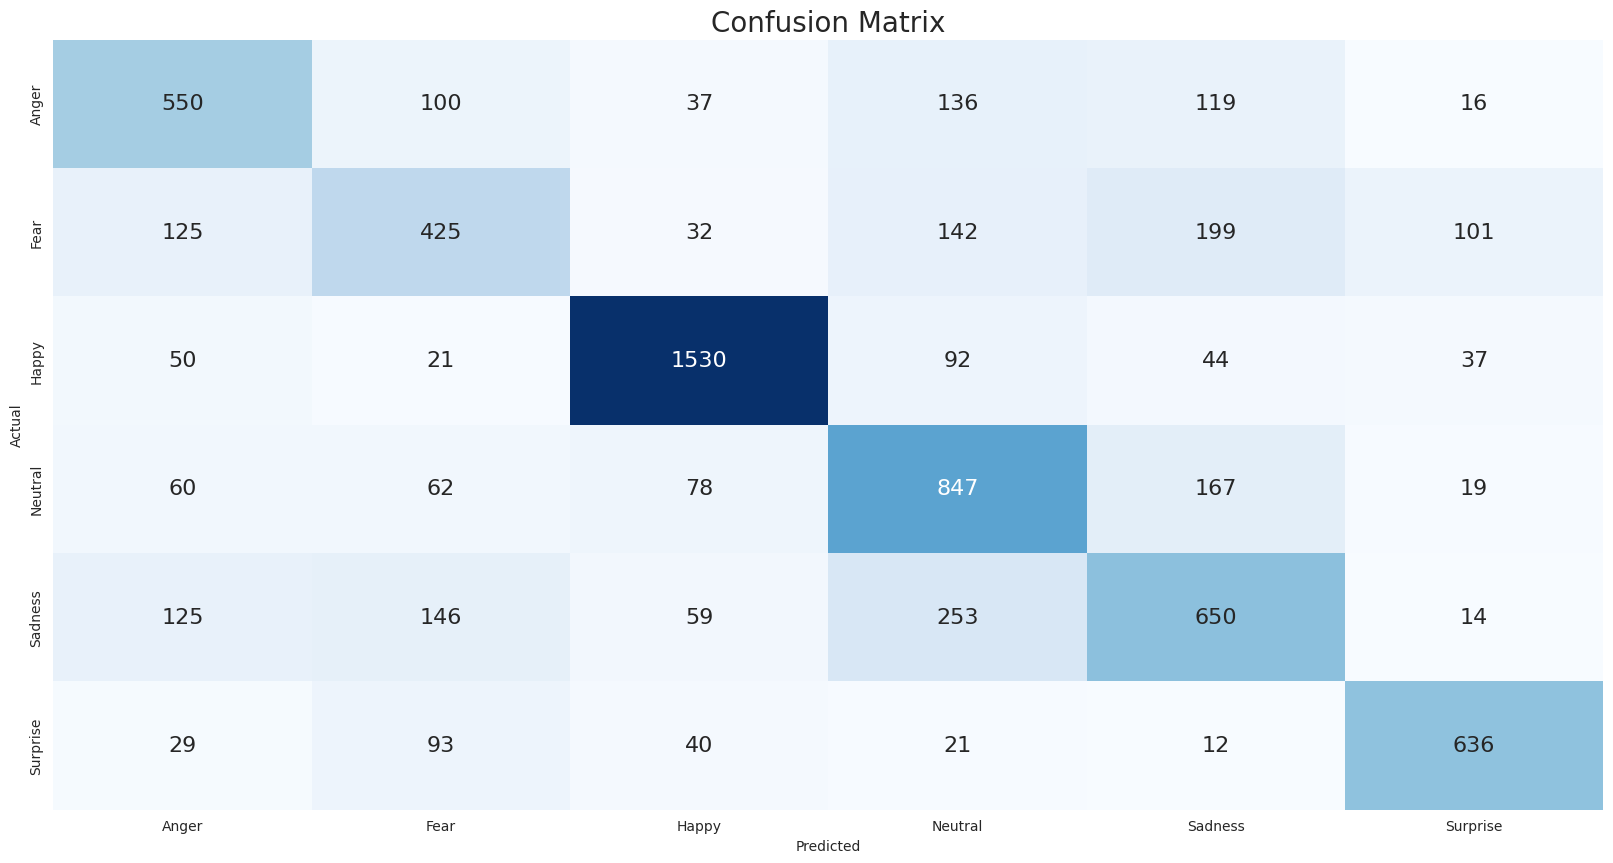

In [13]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [14]:
model.save('../cfg/model.h5')

In [15]:
# ! pip install -q kaggle
# from google.colab import files
#
# files.upload()
# ! mkdir ~/.kaggle
#
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# ! kaggle datasets download -d ananthu017/emotion-detection-fer

In [ ]:
# import zipfile
# import os
#
# data_r = zipfile.ZipFile('/content/emotion-detection-fer.zip', 'r')
# data_r.extractall()

In [ ]:
# import shutil, sys
# shutil.rmtree('/content/test/disgusted')